# <h1><center> Homework 5 </center></h1>

In [791]:
import warnings
warnings.simplefilter('ignore')

from functools import partial

import pandas as pd
import numpy as np
import pandas_profiling as pp

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split, KFold
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.stats import rankdata
from sklearn.svm import SVC
from xgboost import XGBClassifier

%matplotlib inline
import matplotlib as plt
import matplotlib.style as stl
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

plt.rcParams['figure.figsize'] = 16, 10

In [794]:
train = pd.read_csv('../data/train_5.csv', sep='\t', index_col=0)
test = pd.read_csv('../data/test_5.csv', sep='\t', index_col=0)

## <h1><center> EDA </center></h1>

In [27]:
pp.ProfileReport(train[train.columns[1:]])

In [11]:
pp.ProfileReport(test[test.columns[1:]])

Text(0.5,1,'Target distribution')

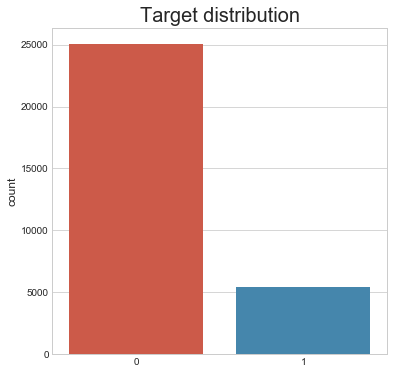

In [800]:
stl.use('seaborn-whitegrid')
plt.pyplot.rcParams['figure.figsize'] = 6,6
sns.countplot(train['0'].values)
plt.pyplot.title('Target distribution', fontsize=20)

## <h1><center>Preprocess</center></h1>

In [314]:
# 9 == 2 in both test and train, 140 and 164 have constant value 0 in both train and test
redundant_columns = ['9', '140', '164'] 
# 11 has constant value 1 in test
use_only_ones = ['11']
# those features have constant value 0 in test
use_only_zeros = ['5', '129', '130', '137', '138', '141', '149', '150', '178', '186', '188', '192', '193', '291', '301', '303', '305']
# those features have constant value 0 inly in train
zero_train_features = ['152', '160']
#too much zeros
too_much_zeros_features = ['191', '182', '185', '181', '172', '170', '157', '136', '135']

In [315]:
#152 and 160 is useless
for feature in zero_train_features:
    print(f"Len of test where {feature} != 0 is {len(test[test[feature]==1])}")
    redundant_columns.append(feature)

Len of test where 152 != 0 is 1
Len of test where 160 != 0 is 1


In [316]:
def preprocess(train_df, test_df):
    _train = train_df.drop(redundant_columns, axis=1)
    _test = test_df.drop(redundant_columns, axis=1)
    for column in use_only_zeros:
        _train = _train[_train[column] == 0].drop(column, axis=1)
        _test.drop(column, axis=1, inplace=True)
    for column in use_only_ones:
        _train = _train[_train[column] == 1].drop(column, axis=1)
        _test.drop(column, axis=1, inplace=True)
    X_train = _train.drop('0', axis=1).reset_index(drop=True)
    y_train = _train['0'].reset_index(drop=True)
    X_test = _test.drop('0', axis=1).reset_index(drop=True)
    return X_train, y_train, X_test

In [317]:
X_train, y_train, X_test = preprocess(train, test)

### Preprocess high correlated features --> bad try

In [526]:
binary_columns = X_train.columns[np.where(X_train.nunique() == 2)[0]]
numeric_columns = X_train.columns[np.where(X_train.nunique() > 2)[0]]

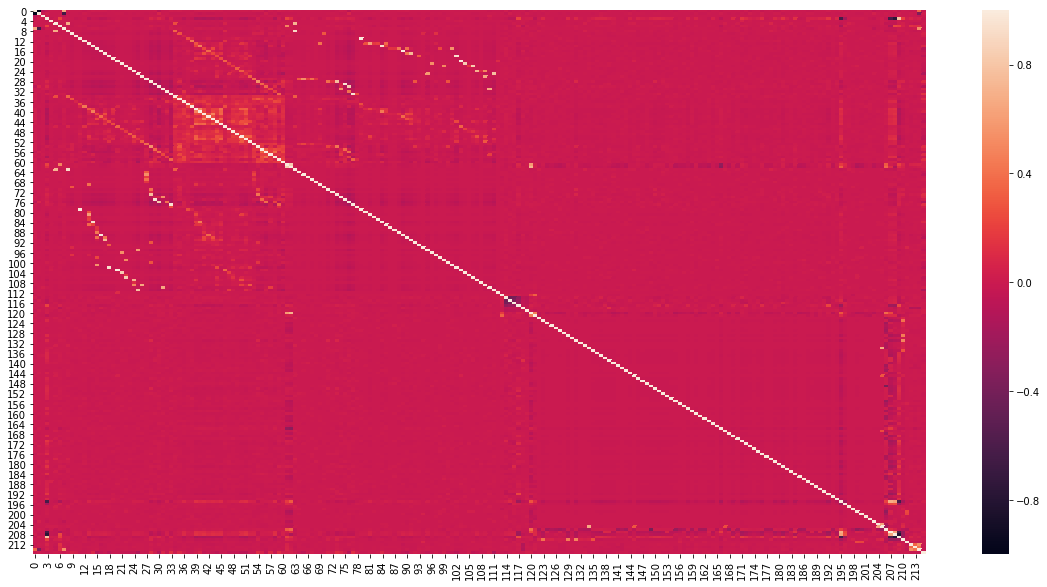

In [645]:
plt.pyplot.rcParams['figure.figsize'] = 20, 10
sns.heatmap(X_train[binary_columns].corr().values)

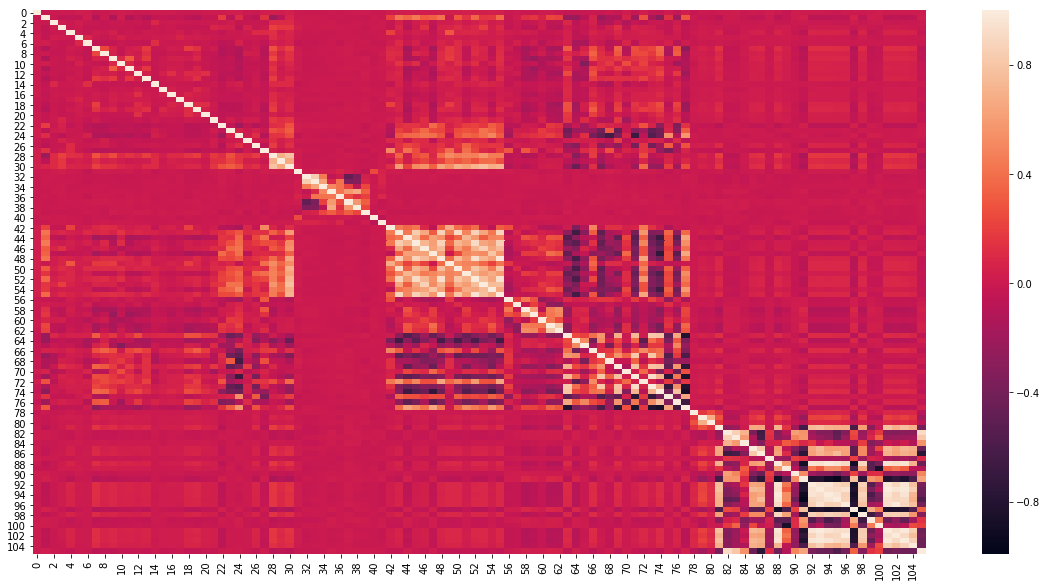

In [646]:
sns.heatmap(X_train[numeric_columns].corr().values)
##если не на гитхаб - лучше делать плотли, тогда можно при наведении мышки узнать начение

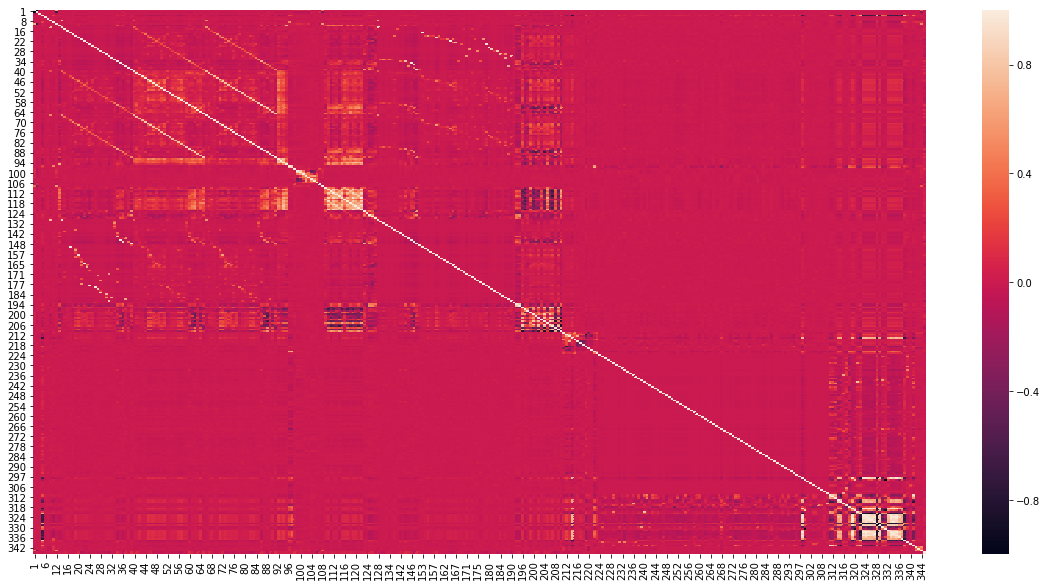

In [647]:
"""trace = go.Heatmap(z=X_train.corr().values)
data=[trace]
iplot(go.Figure(data=[trace]), show_link=True)"""

sns.heatmap(X_train.corr())

In [219]:
high_corelated_features = ['180', '26', '165', '22', '342', '343', '344']


lr = LogisticRegression(random_state=42, n_jobs=-1)
lr_baseline = cross_val_score(estimator=lr, X=X_train, y=y_train, scoring='roc_auc', cv=skf).mean()
print(f"Baseline: {lr_baseline}")


for feature in high_corelated_features:
    X_tmp = X_train.drop(feature, axis=1)
    lr_tmp = cross_val_score(estimator=lr, X=X_tmp, y=y_train, cv=skf, scoring='roc_auc').mean()
    print(f"without {feature} we have {lr_tmp}, diff with baseline: {lr_tmp - lr_baseline}")

Baseline: 0.7268283192571212
without 180 we have 0.7268335791848934, diff with baseline: 5.259927772227613e-06
without 26 we have 0.7268352058370883, diff with baseline: 6.886579967058104e-06
without 165 we have 0.7268063028514427, diff with baseline: -2.201640567855989e-05
without 22 we have 0.7268483797179549, diff with baseline: 2.006046083369295e-05
without 342 we have 0.7266759728730756, diff with baseline: -0.00015234638404559853
without 343 we have 0.7268232033294583, diff with baseline: -5.11592766294644e-06
without 344 we have 0.7266984845718703, diff with baseline: -0.00012983468525096242


### New features engineering --> bad try

In [529]:
##Baseline
lr_baseline = cross_val_score(estimator=lr, X=X_train, y=y_train, scoring='roc_auc', cv=skf).mean()
print(f"Baseline: {lr_baseline}")

Baseline: 0.7268379524285311


In [530]:
def union(row, columns):
    string = ''
    for column in columns:
        column = str(column)
        string += str(int(row[column]))
    return int(string, 2)

In [536]:
X_with_features_train = X_train.copy()
X_with_features_test = X_test.copy()
X_with_features_train['sum_sp'] = X_train[too_much_zeros_features].sum(axis=1)
X_with_features_test['sum_sp'] = X_test[too_much_zeros_features].sum(axis=1)

Text(0.5,0,'Target')

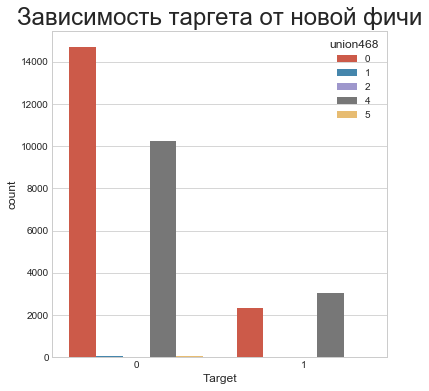

In [803]:
#пробуем обьединить три фичи в одну и рассматривать их комбинации: НАПРИМЕР (100 - это 4 в двоичной системе, так и кодируем)
train_tmp = train.copy()
train_tmp['union468'] = train_tmp.apply(partial(union, columns=['4', '6','8']), axis=1)
X_with_features_train['union468'] = train_tmp['union468'].apply(lambda x: str(x))
X_with_features_test['union468'] = test.apply(partial(union, columns=['4', '6','8']), axis=1).apply(lambda x: str(x))

sns.countplot(train_tmp['0'], hue=train_tmp.union468)
plt.pyplot.title("Зависимость таргета от новой фичи", fontsize=24)
plt.pyplot.xlabel("Target")

In [539]:
sorted(X_with_features_test.union468.unique()) == sorted(X_with_features_train.union468.unique())

True

Text(0.5,0,'Target')

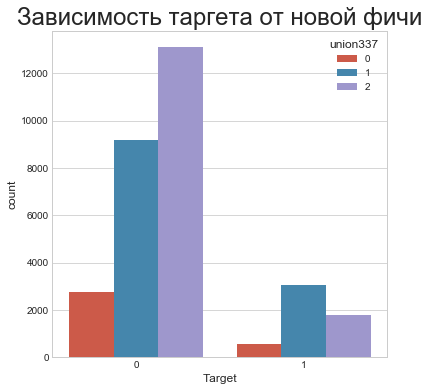

In [804]:
train_tmp['union337'] = train_tmp.apply(partial(union, columns=['337','338']), axis=1)
X_with_features_train['union337'] = train_tmp['union337'].apply(lambda x: str(x))
X_with_features_test['union337'] = test.apply(partial(union, columns=['337', '338']), axis=1).apply(lambda x: str(x))
sns.countplot(train_tmp['0'], hue=train_tmp.union337)
plt.pyplot.title("Зависимость таргета от новой фичи", fontsize=24)
plt.pyplot.xlabel("Target")

In [542]:
sorted(X_with_features_test.union337.unique()) == sorted(X_with_features_train.union337.unique())

True

Text(0.5,0,'Target')

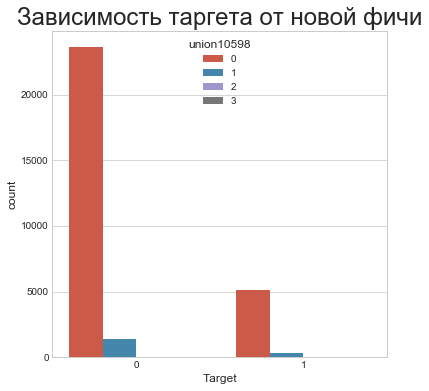

In [805]:
train_tmp['union10598'] = train_tmp.apply(partial(union, columns=['105', '98']), axis=1)
X_with_features_train['union10598'] = train_tmp['union10598'].apply(lambda x: str(x))
X_with_features_test['union10598'] = test.apply(partial(union, columns=['105', '98']), axis=1).apply(lambda x: str(x))

sns.countplot(train_tmp['0'], hue=train_tmp.union10598)
plt.pyplot.title("Зависимость таргета от новой фичи", fontsize=24)
plt.pyplot.xlabel("Target")

In [543]:
sorted(X_with_features_test.union10598.unique()) == sorted(X_with_features_train.union10598.unique())

False

In [544]:
X_with_features_test.union10598.unique()

array(['1', '0', '2'], dtype=object)

In [545]:
X_with_features_train.union10598.unique()

array(['0', '1', '2', '3'], dtype=object)

In [546]:
X_with_features_train = X_with_features_train[X_with_features_train.union10598!=3]

In [547]:
print("With new features")

print(f"Baseline: {lr_baseline}")
with_new_features = cross_val_score(estimator=lr, X= X_with_features_train,
                                    y=y_train, cv=skf, scoring='roc_auc' ).mean()
print(f"we have {with_new_features}, diff with baseline: {with_new_features - lr_baseline}")

With new features
Baseline: 0.7268379524285311
we have 0.7267743691253059, diff with baseline: -6.35833032252009e-05


In [556]:
print("Without high corr features")
X_corr_tr, X_corr_test  = X_train.drop(['180', '22'], axis=1), X_test.drop(['180', '22'], axis=1)

print(f"Baseline: {lr_baseline}")
with_new_features = cross_val_score(estimator=lr, X= X_corr_tr,
                                    y=y_train, cv=skf, scoring='roc_auc' ).mean()
print(f"we have {with_new_features}, diff with baseline: {with_new_features - lr_baseline}")

Without high corr features
Baseline: 0.7268379524285311
we have 0.726872113453269, diff with baseline: 3.416102473785543e-05


In [560]:
X_corr_tr['sum_sp'] = X_corr_tr[too_much_zeros_features].sum(axis=1)
X_corr_test['sum_sp'] = X_corr_test[too_much_zeros_features].sum(axis=1)

print("With sum of spase columns")


print(f"Baseline: {lr_baseline}")
with_new_features = cross_val_score(estimator=lr, X= X_corr_tr,
                                    y=y_train, cv=skf, scoring='roc_auc' ).mean()
print(f"we have {with_new_features}, diff with baseline: {with_new_features - lr_baseline}")

With sum of spase columns
Baseline: 0.7268379524285311
we have 0.7268368165527217, diff with baseline: -1.135875809410436e-06


### One-hot encoding

In [570]:
columns_to_onehot = ['union468', 'union337', 'union10598']
enc = OneHotEncoder()
enc_train = pd.get_dummies(X_with_features_train[columns_to_onehot])
enc_test =  pd.get_dummies(X_with_features_test[columns_to_onehot])

X_onehot_train = pd.concat([X_with_features_train[X_with_features_train.columns[:-len(columns_to_onehot)]], 
                       enc_train], 
                       axis=1, 
                       join_axes=[X_with_features_train.index])
X_onehot_test = pd.concat([X_with_features_test[X_with_features_test.columns[:-len(columns_to_onehot)]],
                       enc_test], 
                       axis=1, 
                       join_axes=[X_test.index])

In [571]:
print("With new onehot_features")


print(f"Baseline: {lr_baseline}")
with_new_features = cross_val_score(estimator=lr, X= X_onehot_train,
                                    y=y_train, cv=skf, scoring='roc_auc' ).mean()
print(f"we have {with_new_features}, diff with baseline: {with_new_features - lr_baseline}")

With new onehot_features
Baseline: 0.7268379524285311
we have 0.7265267843201931, diff with baseline: -0.00031116810833797803


## <h1><center> Validation</center></h1>

In [648]:
#кастомная не оч
kf = KFold(n_splits=10)
skf = StratifiedKFold(n_splits=10)

## <h1><center> All in one methods </center></h1>

In [231]:
def calculate(model, parameters, X_train, y_train, cv_iterator):
    
    gs = GridSearchCV(
    estimator=model,
    param_grid=parameters, 
    cv=cv_iterator, 
    error_score=1,  
    scoring='roc_auc',  
    n_jobs=-1,
    verbose=1)

    gs.fit(X=X_train, y=y_train)

    best_score = gs.best_score_
    best_model = gs.best_estimator_
    
    return best_model, best_score


def get_submission(model, X_train, X_test, y_train, filename):
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:,1]
    make_file(y_pred, filename)
    return y_pred


def make_file(y_pred, filename):
    submission = pd.Series (y_pred, name='_VAL_' )
    submission.to_csv(filename, index_label='_ID_', header =True )

In [238]:
X_without_sparse_train.shape

(30377, 311)

# <h1><center> Logistic Regression </center></h1>

In [406]:
#lb: 0.73664401
lr = LogisticRegression(random_state=42, n_jobs=-1)
params_lr = {'C' : (0.1, 0.15, 0.2, 0.25, 0.5, 0.8, 1)}
best_lr, best_cv_score_lr = calculate(lr, params_lr, X_train, y_train, skf)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   51.7s finished


In [407]:
print(f'CV score for logistic regression: {best_cv_score_lr}')

CV score for logistic regression: 0.728265512270739


In [361]:
lr_predictions = get_submission(best_lr, X_train, X_test, y_train, 'lr_submission.csv')

In [362]:
best_lr

LogisticRegression(C=0.15, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# <h1><center> Bagging </center></h1>

In [396]:
#lb 0.73788434
bgc = BaggingClassifier(base_estimator=best_lr)
params_bgc = {'n_estimators' : (20, 40, 45, 50, 90),
             'max_features' : (0.5, 0.8,0.85, 0.9, 1),
             'bootstrap_features' : (True, False)}
best_bgc, best_cv_score_bgc = calculate(bgc, params_bgc, X_train, y_train, skf)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 41.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 41.4min finished


In [632]:
print(f'CV score for bagging: {best_cv_score_bgc}')

CV score for bagging: 0.7283508207458009


In [399]:
bcg_predictions = get_submission(best_bgc, X_train, X_test, y_train, 'bagging_submission.csv')

In [398]:
best_bgc

BaggingClassifier(base_estimator=LogisticRegression(C=0.15, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=0.9,
         max_samples=1.0, n_estimators=40, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

# <h1><center> Random Forest </center></h1>

In [322]:
#lb = 0.74561287
rf = RandomForestClassifier(random_state=42)
params_rf = {'max_features': (0.05, 0.1, 0.2,1),
            'max_depth': (20,22,25),
            'min_samples_leaf':(10,2),
            'n_estimators':(50,100, 55,60)}
best_rf, best_cv_score_rf = calculate(rf, params_rf, X_train, y_train, skf)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 50.8min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 65.1min finished


In [323]:
print(f'CV score for random forest: {best_cv_score_rf}')

CV score for random forest: 0.7341461809688311


In [324]:
rf_predictions = get_submission(best_rf, X_train, X_test, y_train, 'Random_Forest_try.csv')

In [325]:
best_rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features=0.2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

Text(0.5,1,'Top 10 features')

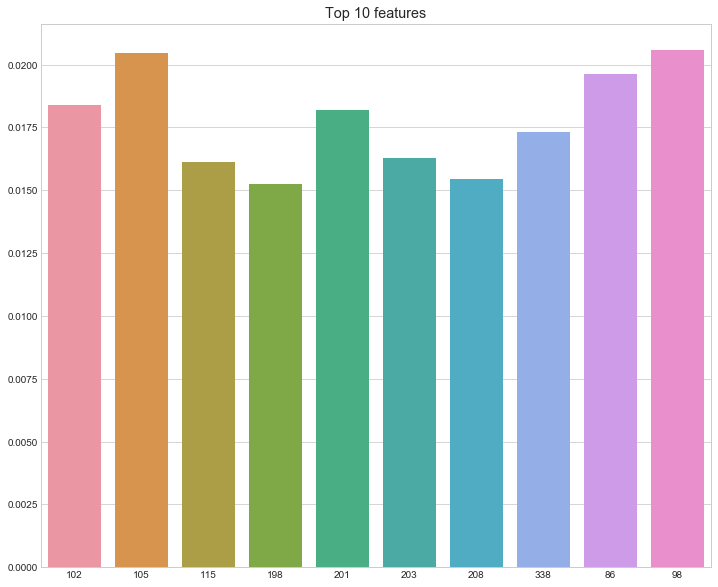

In [807]:
plt.pyplot.rcParams['figure.figsize'] =12, 10
feature_importances_rf = dict(zip(X_train.columns, best_rf.feature_importances_))
top10_rf = sorted(feature_importances_rf.items(), key=lambda x: -x[1])[:10]
fig = sns.barplot(x=[x[0] for x in top10_rf], y=[x[1] for x in top10_rf])
fig.set_title("Top 10 features")

In [481]:
top10_rf

[('98', 0.020595083829271176),
 ('105', 0.020463177329672087),
 ('86', 0.019612444151172911),
 ('102', 0.01840835863016797),
 ('201', 0.01819299269803892),
 ('338', 0.017330465351880837),
 ('203', 0.01629880934739894),
 ('115', 0.016103310758552085),
 ('208', 0.01545472480027605),
 ('198', 0.015234680546616612)]

# <h1> <center> Simple ensemble </center></h1>

In [410]:
lr_pred_cv = []
rf_pred_cv = []
bg_pred_cv = []
k=0
for train, val in skf.split(X_train, y_train):
    k+=1
    print(f"Iteration: {k}")
    best_rf.fit(X_train.iloc[train], y_train[train])
    best_lr.fit(X_train.iloc[train], y_train[train])
    best_bgc.fit(X_train.iloc[train], y_train[train])
    rf_pred_cv.append([y_train[val], best_rf.predict_proba(X_train.iloc[val])[:,1]])
    lr_pred_cv.append([y_train[val], best_lr.predict_proba(X_train.iloc[val])[:,1]])
    bg_pred_cv.append([y_train[val], best_bgc.predict_proba(X_train.iloc[val])[:,1]])

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10


## Rank data

In [345]:
cv_score_rank = np.mean([roc_auc_score(rf_p[0],
                                       rankdata(rf_p[1]) + rankdata(lr_p[1])) for rf_p, lr_p in zip(rf_pred_cv, lr_pred_cv)])

In [346]:
print(f'CV score for rank data: {cv_score_rank}')

CV score for rank data: 0.7409896728495873


In [347]:
#lb 0.75000321
rank_predictions = rankdata(rf_predictions) + rankdata(lr_predictions)
make_file(rank_predictions, 'rank_data_try.scv')

### Rank data with bagging

In [629]:
cv_score_rank_with_bg = np.mean([roc_auc_score(rf_p[0],
                                       rankdata(rf_p[1]) + rankdata(lr_p[1]) + rankdata(bg_p[1])) for rf_p, lr_p, bg_p in zip(rf_pred_cv, lr_pred_cv, bg_pred_cv)])

In [630]:
print(f'CV score for rank data with bagging: {cv_score_rank_with_bg}')

CV score for rank data with bagging: 0.7386452630830976


## Weighted mean

In [585]:
cv_score_weighted_mean = np.mean([roc_auc_score(rf_p[0],
                                                rf_p[1]*0.6 + lr_p[1]*0.4) for rf_p, lr_p in zip(rf_pred_cv, lr_pred_cv)])

In [586]:
print(f'CV score for weighted mean: {cv_score_weighted_mean}')

CV score for weighted mean: 0.741787223741593


In [587]:
#lb 0.75213101
weighted_mean_predictions = 0.6 * rf_predictions + 0.4 * lr_predictions
make_file(weighted_mean_predictions, 'weighted_mean.csv')

# <h1> <center> Stacking </center></h1>

In [590]:
X_train_stacked = X_train.copy()
X_test_stacked = X_test.copy()

X_train_stacked["rf_preds"] = 0
X_train_stacked["lr_preds"] = 0
X_train_stacked["bg_preds"] = 0

X_test_stacked["rf_preds"] = rf_predictions
X_test_stacked["lr_preds"] = lr_predictions
X_test_stacked["bg_preds"] = bcg_predictions

for i, fold in enumerate(skf.split(X_train, y_train)):
    train, val = fold[0], fold[1]
    X_train_stacked.iloc[val, -3] = rf_pred_cv[i][1]
    X_train_stacked.iloc[val, -2] = lr_pred_cv[i][1]
    X_train_stacked.iloc[val, -1] = bg_pred_cv[i][1]

In [591]:
#lb 0.75444914
et = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)
params_et = { 'max_features':(0.5, 0.6),
              'min_samples_leaf': (1,3),
              'max_depth': (10,20)}
best_et_stc, best_cv_score_et_stc = calculate(et, params_et, X_train_stacked, y_train, skf)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 30.3min finished


In [592]:
print(f'CV score for stacking: {best_cv_score_et_stc}')

CV score for stacking: 0.745429174245769


In [593]:
stacking_predictions = get_submission(best_et_stc, X_train_stacked, X_test_stacked, y_train, "stacking.csv")

In [594]:
best_et_stc

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=10, max_features=0.6, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Text(0.5,1,'Top 10 features')

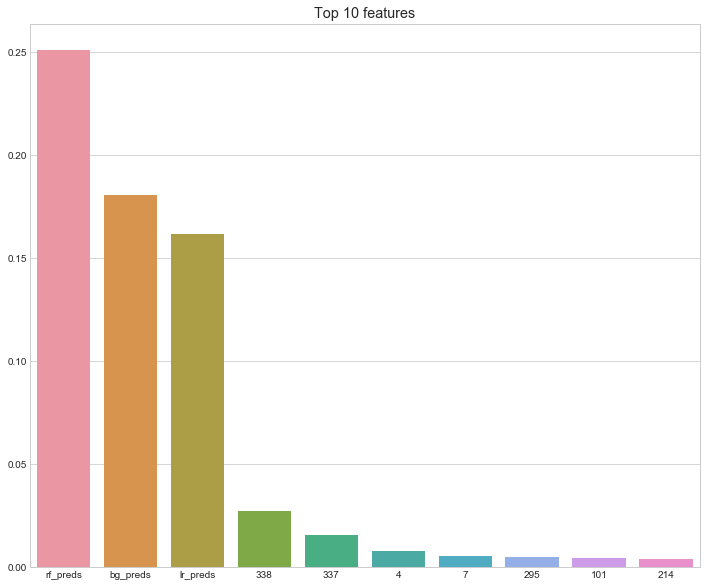

In [810]:
feature_importances_stc = dict(zip(X_train_stacked.columns, best_et_stc.feature_importances_))
top10_stc = dict(sorted(feature_importances_stc.items(), key=lambda x: -x[1])[:10])
fig = sns.barplot(x=list(top10_stc.keys()), y=list(top10_stc.values()))
fig.set_title("Top 10 features")

# <h1><center> Main part summary </center></h1>

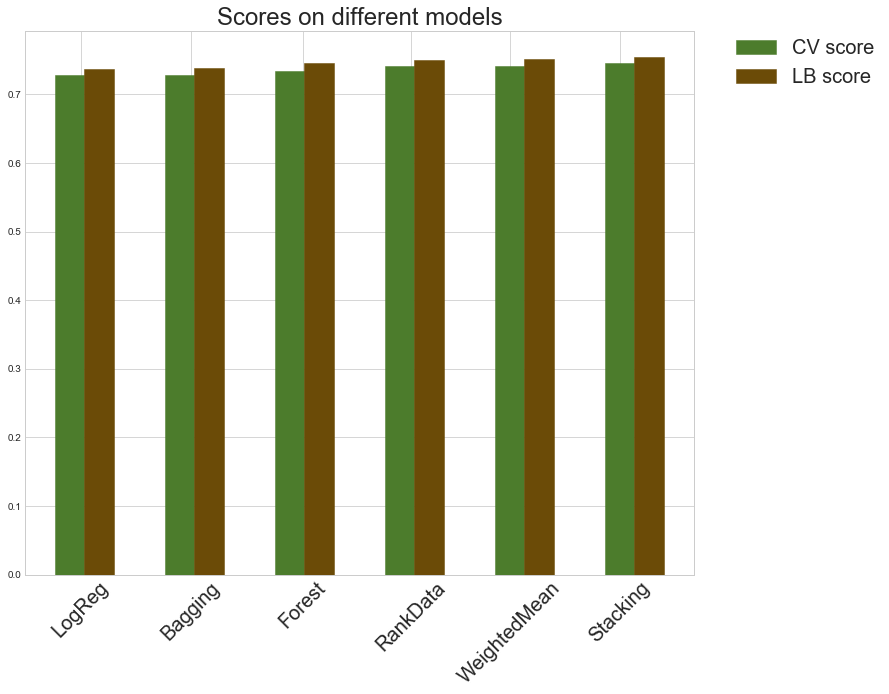

In [812]:
scores = [best_cv_score_lr, 0.73664401,  best_cv_score_bgc,0.73788434, best_cv_score_rf, 0.74561287,
          cv_score_rank,0.75000321, cv_score_weighted_mean, 0.75213101,best_cv_score_et_stc,0.75444914]
labels = ['LogReg', 'Bagging', 'Forest', "RankData", 'WeightedMean', 'Stacking']
pos = [1,1.8,4,4.8,7,7.8, 10,10.8,13,13.8,16,16.8]
barlist = plt.pyplot.bar(pos,scores)
for i in range(12):
    if i%2==0:
        barlist[i].set_color('#4c7c2c')
    else:
        barlist[i].set_color('#6b4b07')
plt.pyplot.xticks([1.3,4.3,7.35,10.3,13,16], labels, fontsize=20, rotation=45)
plt.pyplot.title('Scores on different models', fontsize=24)
green_p = plt.patches.Patch(color='#4c7c2c', label='CV score')
brown_p = plt.patches.Patch(color='#6b4b07', label='LB score')
plt.pyplot.legend(handles=[green_p, brown_p], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 20})

# <h1><center> BEST SOLUTION </center></h1>

## <h1><center> SVC</center></h1>

In [603]:
#lb = 0.69418842
best_svc = SVC(random_state=42, probability=True, C=10)

In [604]:
svc_predictions = get_submission(best_svc, X_train, X_test, y_train, 'svc_try.csv')

# <h1><center> Xgboost</center></h1>

In [612]:
#lb 0.74291409
xgb = XGBClassifier(random_state=42, n_estimators=200)
params_xgb = {
    "max_depth" : (50, 60, 70),
    "learning_rate" : (0.1, 0.2, 0.3)}

best_xgb, best_cv_score_xgb = calculate(xgb, params_xgb, X_train, y_train, skf)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 36.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 68.2min finished


In [613]:
print(f'CV score for xgb: {best_cv_score_xgb}')

CV score for xgb: 0.7240291829263442


In [614]:
xgb_predictions = get_submission(best_xgb, X_train, X_test, y_train, 'xgb_try.csv')

# <h1><center> Let's go party</center></h1>

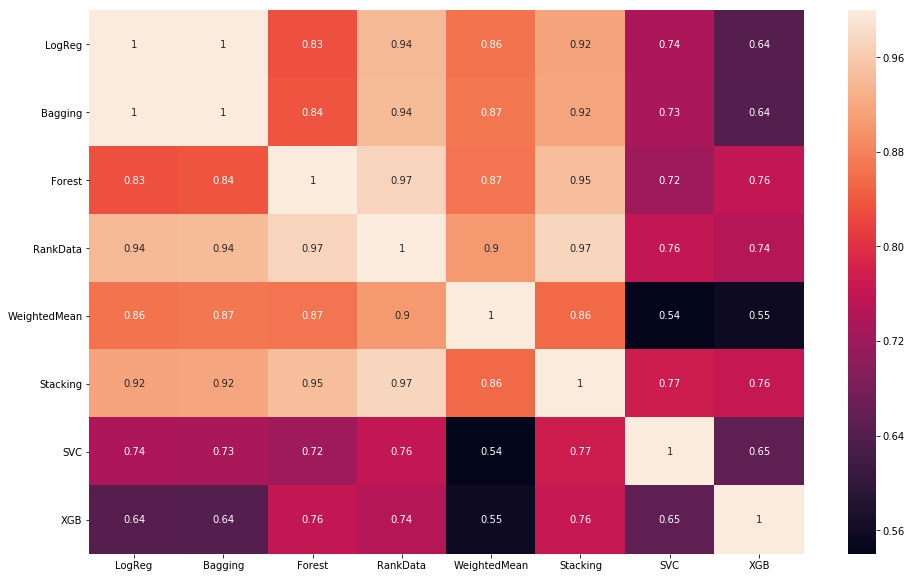

In [631]:
predictions = [lr_predictions, bcg_predictions, rf_predictions,
               weighted_mean_predictions, rank_predictions, stacking_predictions,
              svc_predictions, xgb_predictions]
lbls = ['LogReg', 'Bagging', 'Forest', "RankData", 'WeightedMean', 'Stacking', 'SVC', 'XGB']

sns.heatmap(np.corrcoef(predictions), annot=True, xticklabels=lbls, yticklabels=lbls, center=0)

In [625]:
svc_pred_cv = []
xgb_pred_cv = []
k=0
for train, val in skf.split(X_train, y_train):
    k+=1
    print(f"Iteration: {k}")
    best_svc.fit(X_train.iloc[train], y_train[train])
    best_xgb.fit(X_train.iloc[train], y_train[train])
    svc_pred_cv.append([y_train[val], best_svc.predict_proba(X_train.iloc[val])[:,1]])
    xgb_pred_cv.append([y_train[val], best_xgb.predict_proba(X_train.iloc[val])[:,1]])

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10


## <h1><center> My stacking </center></h1>

In [633]:
X_train_stacked["svc_preds"] = 0
X_train_stacked["xgb_preds"] = 0

X_test_stacked["svc_preds"] = svc_predictions
X_test_stacked["xgb_preds"] = xgb_predictions

for i, fold in enumerate(skf.split(X_train, y_train)):
    train, val = fold[0], fold[1]
    X_train_stacked.iloc[val, -2] = svc_pred_cv[i][1]
    X_train_stacked.iloc[val, -1] = xgb_pred_cv[i][1]

In [634]:
best_et_my_stc, best_cv_score_et_my_stc = calculate(et, params_et, X_train_stacked, y_train, skf)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 29.6min finished


In [635]:
print(f'CV score for stacking: {best_cv_score_et_my_stc}')

CV score for stacking: 0.7467931646034713


In [636]:
#lb 0.75608296
stacking_predictions_my = get_submission(best_et_my_stc, X_train_stacked, X_test_stacked, y_train, "stacking_my.csv")

Text(0.5,1,'Top 10 features')

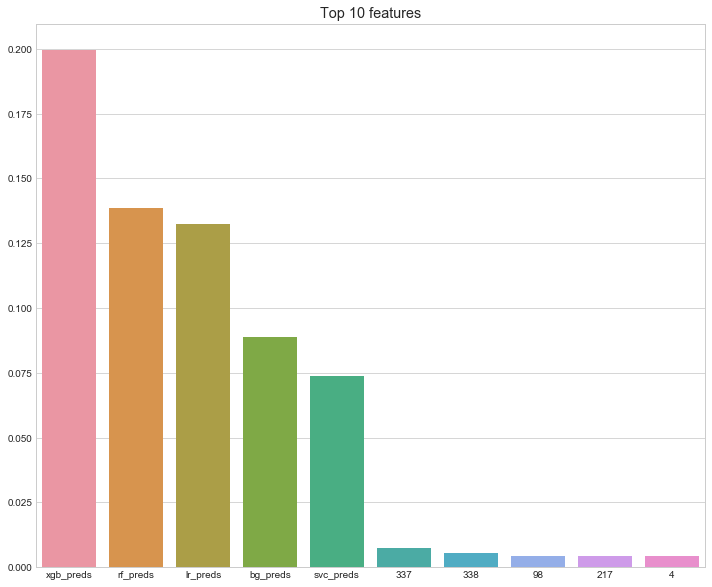

In [813]:
feature_importances_stc = dict(zip(X_train_stacked.columns, best_et_my_stc.feature_importances_))
top10_my_stc = dict(sorted(feature_importances_stc.items(), key=lambda x: -x[1])[:10])
fig = sns.barplot(x=list(top10_my_stc.keys()), y=list(top10_my_stc.values()))
fig.set_title("Top 10 features")

## <h1> <center> Sample ensemble</center></h1>

### Rank data

In [638]:
cv_score_rank_my = np.mean([roc_auc_score(rf_p[0],
                                       rankdata(rf_p[1]) + rankdata(lr_p[1]) + rankdata(xgb_p[1])+rankdata(svc_p[1])) for rf_p, lr_p, xgb_p, svc_p in zip(rf_pred_cv, lr_pred_cv, xgb_pred_cv, svc_pred_cv)])

In [639]:
print(f'CV score for rank data with xgb and svc: {cv_score_rank_my}')

CV score for rank data with xgb and svc: 0.7442337567061841


### Weighted average

In [658]:
cv_score_weighted_mean_xgb = np.mean([roc_auc_score(rf_p[0],
                                                rf_p[1]*0.4 + lr_p[1]*0.2 + xgb_p[1]*0.4) for rf_p, lr_p, xgb_p in zip(rf_pred_cv, lr_pred_cv, xgb_pred_cv)])

In [659]:
print(f'CV score for weighted mean with xgb: {cv_score_weighted_mean_xgb}')

CV score for weighted mean with xgb: 0.7429002155188098


## <h1><center> Two layer stacking</center></h1>

In [660]:
stc_pred_cv = []
k=0
for train, val in skf.split(X_train, y_train):
    k+=1
    print(f"Iteration: {k}")
    best_et_my_stc.fit(X_train_stacked.iloc[train], y_train[train])
    stc_pred_cv.append([y_train[val], best_et_my_stc.predict_proba(X_train_stacked.iloc[val])[:,1]])

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10


In [661]:
X_train_stacked["stc_preds"] = 0

X_test_stacked["stc_preds"] = stacking_predictions_my


for i, fold in enumerate(skf.split(X_train, y_train)):
    train, val = fold[0], fold[1]
    X_train_stacked.iloc[val, -1] = stc_pred_cv[i][1]

In [665]:
params_et_my = { 'max_features':(0.6, 0.8),
              'min_samples_leaf': (1,3),
              'max_depth': (10, 20)}
best_et_two_stc, best_cv_score_et_two_stc = calculate(et, params_et_my, X_train_stacked, y_train, skf)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 37.5min finished


In [666]:
print(f'CV score for two layer stacking: {best_cv_score_et_two_stc}')

CV score for two layer stacking: 0.7470280424470499


In [667]:
#lb 0.75658764
stacking_predictions_my_two_layer = get_submission(best_et_two_stc, X_train_stacked, X_test_stacked, y_train, "stacking_my_two.csv")

Text(0.5,1,'Top 10 features')

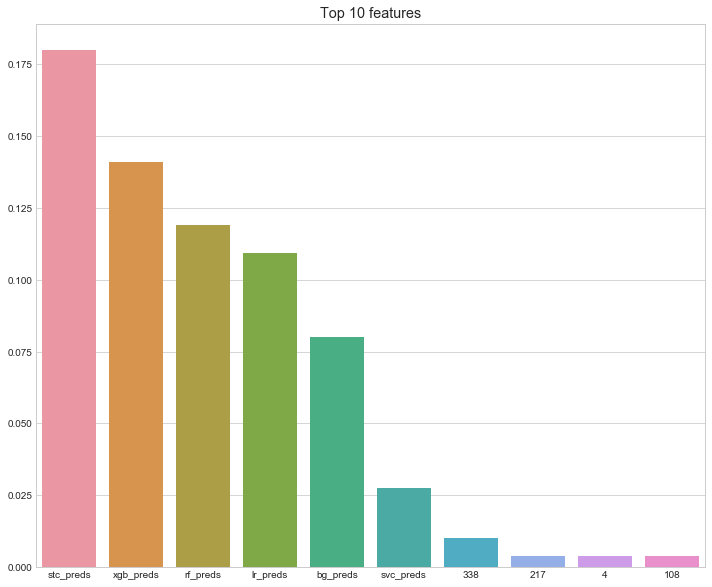

In [814]:
feature_importances_stc = dict(zip(X_train_stacked.columns, best_et_two_stc.feature_importances_))
top10_my_stc2 = dict(sorted(feature_importances_stc.items(), key=lambda x: -x[1])[:10])
fig = sns.barplot(x=list(top10_my_stc2.keys()), y=list(top10_my_stc2.values()))
fig.set_title("Top 10 features")

## <h1><center> Two layer stacking with l1 logreg</center></h1>

In [690]:
lr_l1 = LogisticRegression(random_state=42, penalty='l1', n_jobs=-1)
best_lr_l1_stc_two, best_cv_score_l1_stc_two = calculate(lr_l1, params_lr, X_train_stacked, y_train, skf)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  4.6min finished


In [691]:
print(f'CV score for two layer stacking with l1 logreg: {best_cv_score_l1_stc_two}')

CV score for two layer stacking with l1 logreg: 0.7520253446936692


In [692]:
#lb 0.75837115
stacking_predictions_my_two_layer_l1 = get_submission(best_lr_l1_stc_two, X_train_stacked, X_test_stacked, y_train, "stacking_my_two_l1_new.csv")

Text(0.5,1,'Top 10 features')

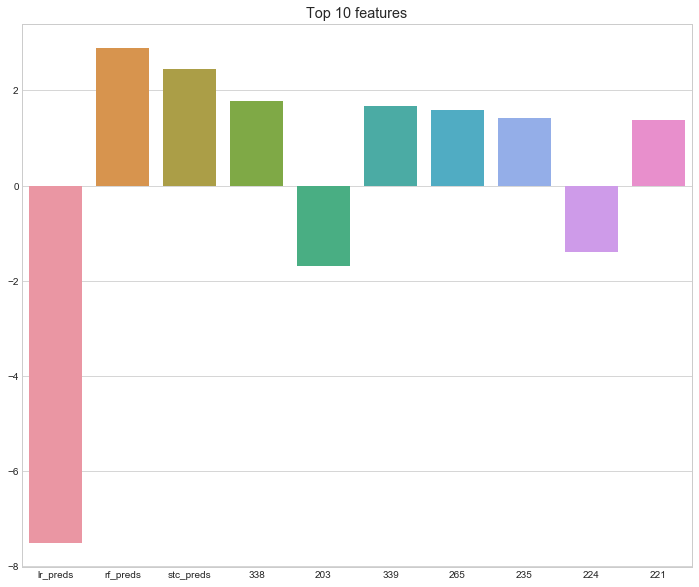

In [815]:
feature_importances_stc = dict(zip(X_train_stacked.columns, best_lr_l1_stc_two.coef_[0]))
top10_my_stc3 = dict(sorted(feature_importances_stc.items(), key=lambda x: -abs(x[1]))[:10])
fig = sns.barplot(x=list(top10_my_stc3.keys()), y=list(top10_my_stc3.values()))
fig.set_title("Top 10 features")

## <h1><center> Logreg only on predictions(like blending)</center></h1>

In [763]:
best_lr_stc, best_cv_score_lr_stc = calculate(lr_l1, params_lr, X_train_stacked.iloc[:, -6:], y_train, skf)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   19.6s finished


In [764]:
best_cv_score_lr_stc

0.74643913381033933

In [768]:
blnd_predictions = get_submission(best_lr_stc, X_train_stacked.iloc[:, -6:], X_test_stacked.iloc[:, -6:], y_train, 'hw5_submissions/blnd.csv')

# <h1><center> Weighted mean of stacking</center></h1>

In [770]:
stc_pred_cv_two = []
stc_pred_cv_two_l1 = []
blnd_pred_cv = []
k=0
for train, val in skf.split(X_train, y_train):
    k+=1
    print(f"Iteration: {k}")
    best_et_two_stc.fit(X_train_stacked.iloc[train], y_train[train])
    stc_pred_cv_two.append([y_train[val], best_et_two_stc.predict_proba(X_train_stacked.iloc[val])[:,1]])
    best_lr_l1_stc_two.fit(X_train_stacked.iloc[train], y_train[train])
    stc_pred_cv_two_l1.append([y_train[val], best_lr_l1_stc_two.predict_proba(X_train_stacked.iloc[val])[:,1]])
    best_lr_stc.fit(X_train_stacked.iloc[train].iloc[:,-6:], y_train[train])
    blnd_pred_cv.append([y_train[val],  best_lr_stc.predict_proba(X_train_stacked.iloc[val].iloc[:, -6:])[:,1]])

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10


In [789]:
cv_score_weight_my_stc = np.mean([roc_auc_score(stc_p[0],
                                       0.05*stc_p[1] + 0.1*stc2_p[1]\
                                      + 0.85*stcl_p[1]) for stc_p, stc2_p, stcl_p \
                                in zip(stc_pred_cv, stc_pred_cv_two,stc_pred_cv_two_l1 )])

In [790]:
print(f"CV score for weighted mean of stackings: {cv_score_weight_my_stc}")

CV score for weighted mean of stackings: 0.7522119343264515


In [719]:
#lb 0.75894854
weight_stc = 0.85 * stacking_predictions_my_two_layer_l1 + 0.1 * stacking_predictions_my_two_layer + 0.05 * stacking_predictions_my
make_file(weight_stc, "weight.csv")

## <h1><center> Three layer stacking</center></h1>

In [826]:
X_train_stacked["stc_preds_2"] = 0

X_test_stacked["stc_preds_2"] = stacking_predictions_my_two_layer_l1


for i, fold in enumerate(skf.split(X_train, y_train)):
    train, val = fold[0], fold[1]
    X_train_stacked.iloc[val, -1] = stc_pred_cv_two_l1[i][1]

In [828]:
lr_l1 = LogisticRegression(random_state=42, penalty='l1', n_jobs=-1)
best_lr_l1_stc_three, best_cv_score_l1_stc_three = calculate(lr_l1, params_lr, X_train_stacked, y_train, skf)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  5.3min finished


In [829]:
print(f'CV score for three layer stacking with l1 logreg: {best_cv_score_l1_stc_three}')

CV score for three layer stacking with l1 logreg: 0.7551685267151711


In [830]:
#lb 0.76101006
stacking_predictions_my_three_layer_l1 = get_submission(best_lr_l1_stc_three, X_train_stacked, X_test_stacked, y_train, "stacking_my_three_l1_new.csv")

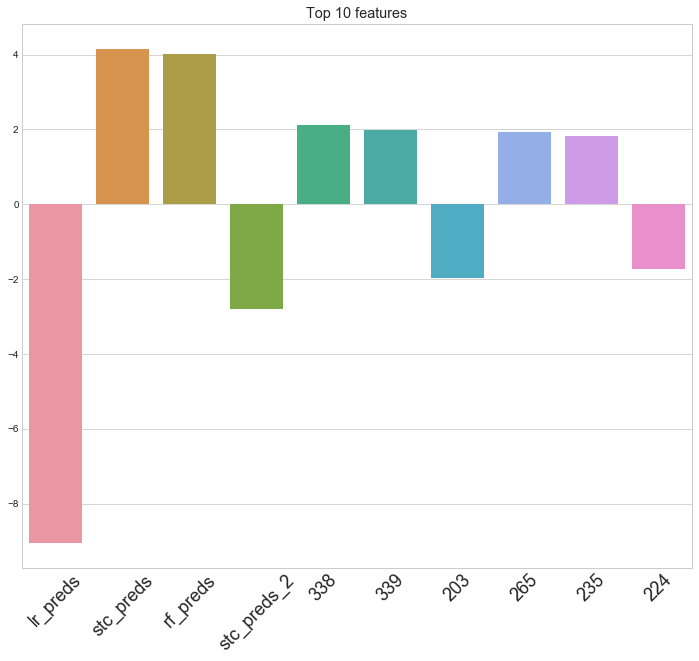

In [850]:
feature_importances_stc = dict(zip(X_train_stacked.columns, best_lr_l1_stc_three.coef_[0]))
top10_my_stc3 = dict(sorted(feature_importances_stc.items(), key=lambda x: -abs(x[1]))[:10])
fig = sns.barplot(x=list(top10_my_stc3.keys()), y=list(top10_my_stc3.values()))
fig.set_title("Top 10 features")
fig.tick_params(axis='x', which='major', labelsize=18, rotation=45)

# <h1><center> Let's sum up</center></h1>

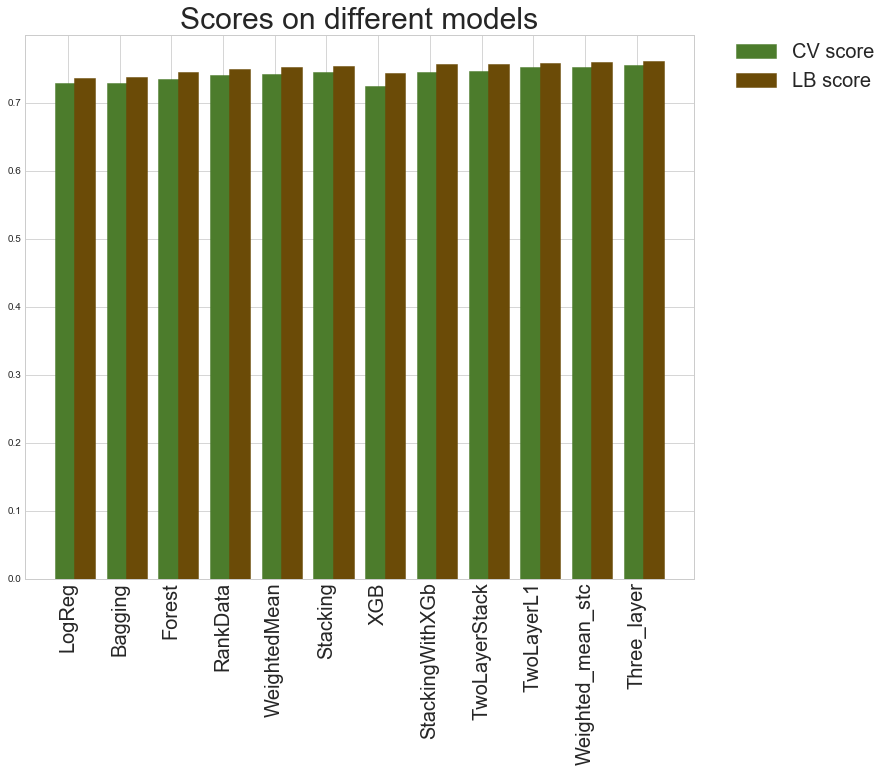

In [839]:
scores = [best_cv_score_lr, 0.73664401,  best_cv_score_bgc,0.73788434, best_cv_score_rf, 0.74561287,
          cv_score_rank,0.75000321, cv_score_weighted_mean, 0.75213101,best_cv_score_et_stc,0.75444914,
          best_cv_score_xgb, 0.74291409, best_cv_score_et_stc, 0.75608296, best_cv_score_et_two_stc, 0.75658764,
         best_cv_score_l1_stc_two, 0.75837115, cv_score_weight_my_stc, 0.75894854, best_cv_score_l1_stc_three,0.76101006 ]
labels = ['LogReg', 'Bagging', 'Forest', "RankData", 'WeightedMean', 'Stacking',
         'XGB', 'StackingWithXGb', 'TwoLayerStack', "TwoLayerL1", "Weighted_mean_stc", "Three_layer"]
pos = [i+1 if i%2==0 else i+0.75 for i in range(24)]
barlist = plt.pyplot.bar(pos,scores)
for i in range(24):
    if i%2==0:
        barlist[i].set_color('#4c7c2c')
    else:
        barlist[i].set_color('#6b4b07')
plt.pyplot.xticks([i+1.1 for i in range(0, 24,2)],labels, fontsize=20, rotation=90)
plt.pyplot.title('Scores on different models', fontsize=30)
green_p = plt.patches.Patch(color='#4c7c2c', label='CV score')
brown_p = plt.patches.Patch(color='#6b4b07', label='LB score')
plt.pyplot.legend(handles=[green_p, brown_p], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 20})